In [49]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

In [7]:
corpus = re.sub(r'[\d\t,.?!―]', '', open('Corpus_sentences_in_Russian.txt', 'r', encoding='utf8').read()).lower().split('\n')[:-1]
corpus[:10]

['на болотах оставался ещё лёд но на берегах реки появилась трава',
 'он ловко поддел концом ножа замочки и они отскочили',
 'ваня раскрыл было рот но понял что что-то не так и промолчал',
 'сделав мне знак помолчать он приложил ухо к двери',
 'я сделала шаг навстречу: приехала к ней попросив выслушать меня',
 'дорога ведет в глухой лес петляя по склонам',
 'не поручайте мужу ухаживать за рыбками в аквариуме он обязательно забудет',
 'выходя замуж ты надеялась обрести спокойствие уютный дом крепкую семью',
 'и не надо ставить это целью всей своей жизни',
 'у нас в волгограде многие придерживаются иной точки зрения']

In [8]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)
print(tokenized_corpus)

[['на', 'болотах', 'оставался', 'ещё', 'лёд', 'но', 'на', 'берегах', 'реки', 'появилась', 'трава'], ['он', 'ловко', 'поддел', 'концом', 'ножа', 'замочки', 'и', 'они', 'отскочили'], ['ваня', 'раскрыл', 'было', 'рот', 'но', 'понял', 'что', 'что-то', 'не', 'так', 'и', 'промолчал'], ['сделав', 'мне', 'знак', 'помолчать', 'он', 'приложил', 'ухо', 'к', 'двери'], ['я', 'сделала', 'шаг', 'навстречу:', 'приехала', 'к', 'ней', 'попросив', 'выслушать', 'меня'], ['дорога', 'ведет', 'в', 'глухой', 'лес', 'петляя', 'по', 'склонам'], ['не', 'поручайте', 'мужу', 'ухаживать', 'за', 'рыбками', 'в', 'аквариуме', 'он', 'обязательно', 'забудет'], ['выходя', 'замуж', 'ты', 'надеялась', 'обрести', 'спокойствие', 'уютный', 'дом', 'крепкую', 'семью'], ['и', 'не', 'надо', 'ставить', 'это', 'целью', 'всей', 'своей', 'жизни'], ['у', 'нас', 'в', 'волгограде', 'многие', 'придерживаются', 'иной', 'точки', 'зрения'], ['очень', 'тогда', 'злые', 'попадались', 'люди'], ['на', 'привале', 'у', 'озера', 'юный', 'турист', '

In [9]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [10]:
print(word2idx)

{'на': 0, 'болотах': 1, 'оставался': 2, 'ещё': 3, 'лёд': 4, 'но': 5, 'берегах': 6, 'реки': 7, 'появилась': 8, 'трава': 9, 'он': 10, 'ловко': 11, 'поддел': 12, 'концом': 13, 'ножа': 14, 'замочки': 15, 'и': 16, 'они': 17, 'отскочили': 18, 'ваня': 19, 'раскрыл': 20, 'было': 21, 'рот': 22, 'понял': 23, 'что': 24, 'что-то': 25, 'не': 26, 'так': 27, 'промолчал': 28, 'сделав': 29, 'мне': 30, 'знак': 31, 'помолчать': 32, 'приложил': 33, 'ухо': 34, 'к': 35, 'двери': 36, 'я': 37, 'сделала': 38, 'шаг': 39, 'навстречу:': 40, 'приехала': 41, 'ней': 42, 'попросив': 43, 'выслушать': 44, 'меня': 45, 'дорога': 46, 'ведет': 47, 'в': 48, 'глухой': 49, 'лес': 50, 'петляя': 51, 'по': 52, 'склонам': 53, 'поручайте': 54, 'мужу': 55, 'ухаживать': 56, 'за': 57, 'рыбками': 58, 'аквариуме': 59, 'обязательно': 60, 'забудет': 61, 'выходя': 62, 'замуж': 63, 'ты': 64, 'надеялась': 65, 'обрести': 66, 'спокойствие': 67, 'уютный': 68, 'дом': 69, 'крепкую': 70, 'семью': 71, 'надо': 72, 'ставить': 73, 'это': 74, 'целью':

In [11]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append(np.array([indices[center_word_pos], context_word_idx]))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [12]:
idx_pairs[:10]

array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 2],
       [1, 3],
       [2, 0],
       [2, 1],
       [2, 3],
       [2, 4],
       [3, 1]])

In [13]:
def get_input_layer(words_idx):
    x = torch.zeros(words_idx.shape[0], vocabulary_size).float()
    x[list(range(0, words_idx.shape[0])), words_idx] = 1.
    return x

In [58]:
embedding_dims = 15

class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.input = nn.Linear(vocabulary_size, embedding_dims)
        self.out = nn.Linear(embedding_dims, vocabulary_size)
        
    def forward(self, x):
        hidden = self.input(x)
        x = F.relu(hidden)
        x = self.out(x)
        
        return x

In [59]:
learning_rate = 0.001
model = MyModule()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
num_epochs = 1010
losses = []
batch_size = 128
for epo in range(num_epochs):
    loss_val = 0
    idx = np.random.permutation(np.arange(0, idx_pairs.shape[0]))
    for i, batch in enumerate(range(0, idx_pairs.shape[0], batch_size)):  
        x = get_input_layer(idx_pairs[batch:batch+batch_size, 0]).to(device)
        y_true = torch.from_numpy(np.array([idx_pairs[batch:batch+batch_size, 1]])).long().to(device)

        out = model(x)
        loss = criterion(out, y_true.view(-1))
        loss_val += loss.data.item()
        loss.backward()
        optim.step()
        
        model.zero_grad()
    losses.append(loss_val/i)
    if epo % 25 == 0:    
        print(f'Loss at epo {epo}: {loss_val/i}')

Loss at epo 0: 7.1331294195992605
Loss at epo 25: 6.457021617889405
Loss at epo 50: 5.991175310952323
Loss at epo 75: 5.193436813354492
Loss at epo 100: 4.22838226727077
Loss at epo 125: 3.471160956791469
Loss at epo 150: 3.015098237991333
Loss at epo 175: 2.7407902581351142
Loss at epo 200: 2.5586358751569476
Loss at epo 225: 2.429205972807748
Loss at epo 250: 2.3340955495834352
Loss at epo 275: 2.2628369092941285
Loss at epo 300: 2.2087081500462125
Loss at epo 325: 2.1671231440135412
Loss at epo 350: 2.1347480842045377
Loss at epo 375: 2.109299397468567
Loss at epo 400: 2.089124812398638
Loss at epo 425: 2.0728701863970076
Loss at epo 450: 2.0597560576030185
Loss at epo 475: 2.0491274867738998
Loss at epo 500: 2.040248084068298
Loss at epo 525: 2.0329950298581805
Loss at epo 550: 2.0269989490509035
Loss at epo 575: 2.021835105759757
Loss at epo 600: 2.0174763679504393
Loss at epo 625: 2.0137676000595093
Loss at epo 650: 2.0106213365282333
Loss at epo 675: 2.007970632825579
Loss at ep

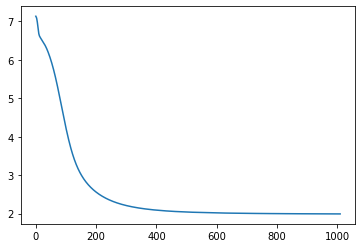

In [61]:
plt.plot(list(range(0, num_epochs, 1)), losses)

In [63]:
model.eval()
preds = np.ones((len(idx2word), embedding_dims))
for idx, i in enumerate(idx2word.keys()):
  x = get_input_layer(np.array([i])).to(device)
  out = model.input(x)
  preds[idx] = out.detach().cpu().numpy()
print(preds)

[[ 5.53117275e-01  5.52474928e+00  2.76167393e+00 ...  1.12262022e+00
   1.01087189e+00  4.31740880e-01]
 [ 1.18231630e+00  2.28306293e+00  4.61442661e+00 ...  3.93774557e+00
   2.46577287e+00 -2.23927498e-02]
 [ 1.65677857e+00  1.54124665e+00  5.89578915e+00 ...  4.33211136e+00
  -4.53412533e-03 -5.89179993e-03]
 ...
 [ 4.02630091e+00  4.80817842e+00 -3.08724642e-02 ...  3.08066559e+00
   1.32147610e+00  2.55987525e-01]
 [ 8.99683654e-01  4.62426758e+00 -4.96745110e-04 ...  5.81769371e+00
   4.66943741e+00 -2.09828615e-02]
 [ 5.63404465e+00  4.29590607e+00  6.99436665e-03 ...  4.80378962e+00
   2.72028255e+00 -1.85670853e-02]]


In [65]:
vec_embedded = TSNE(n_components=2).fit_transform(preds)
vec_embedded

array([[  7.071991 ,   9.791204 ],
       [  7.7426357, -16.650112 ],
       [  8.33626  , -17.5689   ],
       ...,
       [-14.923065 , -28.99321  ],
       [ -5.0675616,  -6.9476333],
       [-14.749037 , -28.399145 ]], dtype=float32)

In [66]:
data = pd.concat([pd.DataFrame(vec_embedded), pd.Series(list(word2idx.keys()))], axis=1)
data.columns = ['x', 'y', 'word']
data

,x,y,word
0,7.071991,9.791204,на
1,7.742636,-16.650112,болотах
2,8.336260,-17.568899,оставался
3,-23.031334,16.099730,ещё
4,7.575021,-16.375233,лёд
...,...,...,...
998,-14.998457,-29.909273,наблюдателя
999,-13.960667,-32.174339,должна
1000,-14.923065,-28.993210,ускользать
1001,-5.067562,-6.947633,малейшая


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x720 with 0 Axes>

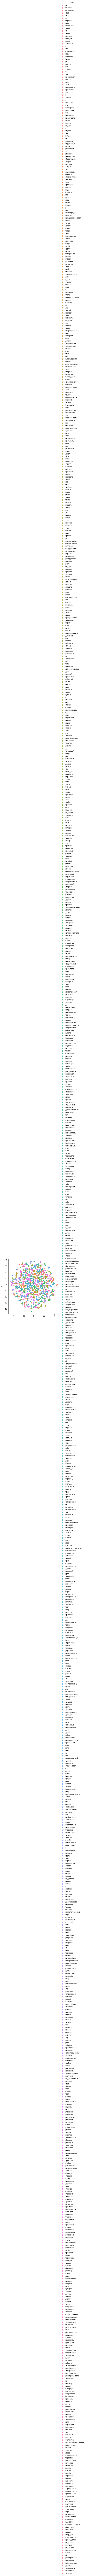

In [68]:
plt.figure(figsize=(10, 10))
sns.lmplot('x', 'y', data=data, hue='word', fit_reg=False, legend=True)
plt.show()